In [5]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# 데이터 로드
url = 'https://raw.githubusercontent.com/MyungKyuYi/AI-class/main/abalone.csv'
data = pd.read_csv(url)

# 범주형 데이터 수치형으로 변환
label_encoder = LabelEncoder()
data['Sex'] = label_encoder.fit_transform(data['Sex'])


def feature_eng(df):
    
    # 특성 엔지니어링
    df['Length_to_Diameter'] = df['Length'] / df['Diameter']
    df['Weight_Ratio'] = df['Shucked_weight'] / df['Whole_weight']

    df['Water'] = df['Whole_weight'] - df['Shucked_weight'] - df['Viscera_weight'] - df['Shell_weight']
    df['new'] = df['Shell_weight']+df['Height']
    df['Length_Diameter_Product'] = df['Length'] * df['Diameter']
    df['Shell_Weight_Ratio'] = df['Shell_weight'] / df['Whole_weight']

    # 부피와 밀도 계산 전에 0으로 나누는 것을 방지
    df['Volume'] = df['Length'] * df['Height'] * df['Diameter']
    df['Density'] = df['Whole_weight'] / df['Volume']
    df.replace([np.inf, -np.inf], np.nan, inplace=True)  # 무한대 값 NaN으로 대체
    df.dropna(inplace=True)  # NaN 값 제거
    
    return df

# 특성공학 
data = feature_eng(data)

# 'Rings'를 범주형 데이터로 변환 (예: 3개 범주로 분류)
data['Age_Category'] = pd.cut(data['Rings'], bins=[0, 8, 12, np.inf], labels=[0, 1, 2])

# # 원-핫 인코딩
# data = pd.get_dummies(data, columns=['Sex'])
# sex_columns = [col for col in data.columns if col.startswith('Sex')]
# data[sex_columns] = data[sex_columns].astype(int)

print(data)

# 특성과 타겟 분리
X = data.drop(['Rings', 'Age_Category'], axis=1)
y = to_categorical(data['Age_Category'])  # 원-핫 인코딩

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



        id  Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  \
0        0    2   0.455     0.365   0.095        0.5140          0.2245   
1        1    2   0.350     0.265   0.090        0.2255          0.0995   
2        2    0   0.530     0.420   0.135        0.6770          0.2565   
3        3    2   0.440     0.365   0.125        0.5160          0.2155   
4        4    1   0.330     0.255   0.080        0.2050          0.0895   
...    ...  ...     ...       ...     ...           ...             ...   
4172  4172    0   0.565     0.450   0.165        0.8870          0.3700   
4173  4173    2   0.590     0.440   0.135        0.9660          0.4390   
4174  4174    2   0.600     0.475   0.205        1.1760          0.5255   
4175  4175    0   0.625     0.485   0.150        1.0945          0.5310   
4176  4176    2   0.710     0.555   0.195        1.9485          0.9455   

      Viscera_weight  Shell_weight  Rings  Length_to_Diameter  Weight_Ratio  \
0             0.1010

In [6]:
from tensorflow.keras.layers import Conv1D, Flatten, BatchNormalization, MaxPooling1D

# 데이터의 형태를 (샘플 수, 특성 수, 1)로 변환하여 CNN에 적용할 수 있도록 변경
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# CNN 모델 구성
model = Sequential([
    Conv1D(64, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Conv1D(128, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])




C:\Users\Hyeon\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=30, verbose=1)

# 모델 훈련
history = model.fit(X_train_cnn, y_train, validation_data=(X_test_cnn, y_test), epochs=1000, batch_size=32, verbose=1, callbacks=[early_stopping, reduce_lr])


Epoch 1/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5554 - loss: 0.9503 - val_accuracy: 0.6886 - val_loss: 0.9540 - learning_rate: 0.0010
Epoch 2/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6835 - loss: 0.7522 - val_accuracy: 0.7030 - val_loss: 0.8460 - learning_rate: 0.0010
Epoch 3/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6771 - loss: 0.7300 - val_accuracy: 0.7054 - val_loss: 0.7287 - learning_rate: 0.0010
Epoch 4/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6901 - loss: 0.6981 - val_accuracy: 0.6982 - val_loss: 0.6776 - learning_rate: 0.0010
Epoch 5/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7118 - loss: 0.6726 - val_accuracy: 0.7246 - val_loss: 0.6319 - learning_rate: 0.0010
Epoch 6/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7234 - loss: 0.6707 - val_accuracy: 0.7090 - val_loss: 0.6461 - learning_rate: 0.0010
Epoch 7/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6943 - l

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7418 - loss: 0.5934 - val_accuracy: 0.7174 - val_loss: 0.6322 - learning_rate: 0.0010
Epoch 45/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7523 - loss: 0.5758 - val_accuracy: 0.7293 - val_loss: 0.6215 - learning_rate: 0.0010
Epoch 46/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7320 - loss: 0.5802 - val_accuracy: 0.7186 - val_loss: 0.6268 - learning_rate: 0.0010
Epoch 47/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7328 - loss: 0.5652 - val_accuracy: 0.7090 - val_loss: 0.6262 - learning_rate: 0.0010
Epoch 48/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7472 - loss: 0.5751 - val_accuracy: 0.7174 - val_loss: 0.6200 - learning_rate: 0.0010
Epoch 49/1000
100/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7342 - loss: 0.5734
Epoch 49: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7343 - loss: 0.57

Epoch 84: early stopping
Restoring model weights from the end of the best epoch: 54.


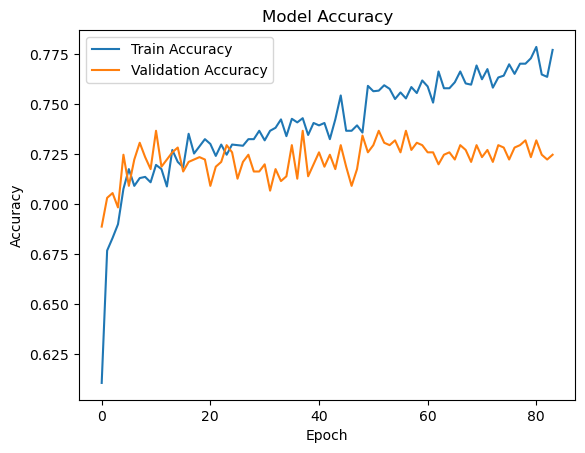

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.7159 - loss: 0.6118
Test Accuracy: 0.7293


In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# 모델 성능 평가 (정확도 계산)
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


In [ ]:
# 데이터 형태에 맞춰서 모델 훈련 (여기서는 데이터 분리 과정이 필요)
# 이후 X_train_infant, X_train_male, X_train_female에 맞춰 훈련 진행
# 예시:
# model.fit([X_train_infant, X_train_male, X_train_female], y_train, epochs=20, batch_size=32)